In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pandas as pd
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define a base path in your Google Drive to save outputs
data_path = '/content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Deberta_results/config_4/fold_2'
drive_base_path = '/content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results'
Deberta_data_path = '/content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Deberta_data'
report_path = '/content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Deberta_results/config_4/fold_2'
import os
os.makedirs(drive_base_path, exist_ok=True)
os.makedirs(Deberta_data_path, exist_ok=True)
os.makedirs(report_path, exist_ok=True)

Mounted at /content/drive


In [ ]:
def filter_short_words(text, min_len=3):
    return " ".join([word for word in text.split() if len(word) >= min_len])

In [ ]:
def is_date_token(token):
    # Rebuild combined regex pattern for date tokens
    patterns = [
      # Month names
      r'\b(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:t(?:ember)?)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)\b',
      # 4-digit years
      r'\b\d{4}\b',
      # Numeric dates
      r'\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b',
      r'\b\d{4}[/-]\d{1,2}[/-]\d{1,2}\b',
      # Month + day
      r'\b(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:t(?:ember)?)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)\s+\d{1,2}\b',
      # Day + month
      r'\b\d{1,2}\s+(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:t(?:ember)?)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)\b',
      # Month + year
      r'\b(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:t(?:ember)?)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)\s+\d{4}\b',
      # Year + month
      r'\b\d{4}\s+(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:t(?:ember)?)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)\b',
      # Weekday names
      r'\b(?:mon(?:day)?|tue(?:sday)?|wed(?:nesday)?|thu(?:rsday)?|fri(?:day)?|sat(?:urday)?|sun(?:day)?)\b',
      # Weekday + day
      r'\b(?:mon(?:day)?|tue(?:sday)?|wed(?:nesday)?|thu(?:rsday)?|fri(?:day)?|sat(?:urday)?|sun(?:day)?)\s+\d{1,2}\b'
  ]

    combined_pattern = re.compile('|'.join(patterns), flags=re.IGNORECASE)

    # Since tokens are usually single words or ngrams without spaces,
    # we check if the token matches the date pattern.
    return bool(combined_pattern.fullmatch(token.strip()))

In [ ]:
df = pd.read_csv(os.path.join(data_path, 'misclassified.csv'))

In [ ]:
# Features of misclassified emails
df["has_link"] = df["cleaned text"].str.contains(r"http[s]?", na=False)
df["has_login"] = df["cleaned text"].str.contains("login|log in|sign in|account", flags=re.I, na=False)
df["has_urgent"] = df["cleaned text"].str.contains("urgent|immediately|verify|attention", flags=re.I, na=False)
#df["email_length"] = df["cleaned text"].str.len()

print(df.groupby("has_link")["predicted_label"].value_counts())
print(df.groupby("has_login")["predicted_label"].value_counts())
print(df.groupby("has_urgent")["predicted_label"].value_counts())
print(f"Emails lengths: Min = {min(df['email length'])}, Max = {max(df['email length'])}, Avg = {df['email length'].mean():.2f}")

has_link  predicted_label
False     1                  23
          0                   9
True      0                  13
          1                   9
Name: count, dtype: int64
has_login  predicted_label
False      1                  30
           0                  20
True       0                   2
           1                   2
Name: count, dtype: int64
has_urgent  predicted_label
False       1                  32
            0                  20
True        0                   2
Name: count, dtype: int64
Emails lengths: Min = 19, Max = 10750, Avg = 1503.93


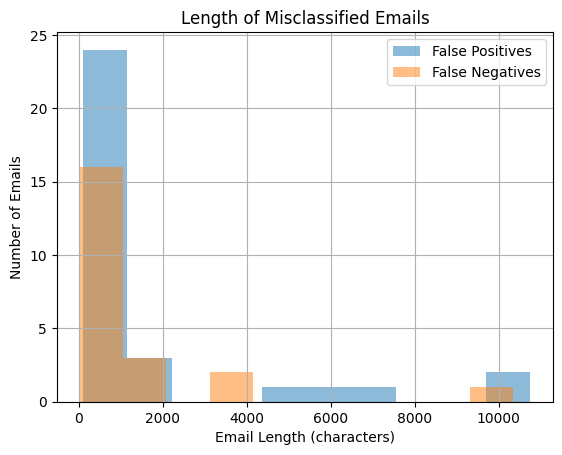

In [ ]:
# Plot lengths
fp = df[(df["label"] == 0) & (df["predicted_label"] == 1)]  # Legit → Phish
fn = df[(df["label"] == 1) & (df["predicted_label"] == 0)]  # Phish → Legit
fp["email length"].hist(alpha=0.5, label="False Positives")
fn["email length"].hist(alpha=0.5, label="False Negatives")
plt.legend()
plt.title("Length of Misclassified Emails")
plt.xlabel("Email Length (characters)")  # Label for the x-axis
plt.ylabel("Number of Emails")           # Label for the y-axis
plt.savefig(os.path.join(report_path, "misclassified_emails_length.png"))  # Save the figure as PNG
plt.show()

In [ ]:
# Wordcloud
fp_text_filtered = filter_short_words(" ".join(fp["cleaned text"].dropna()))
fn_text_filtered = filter_short_words(" ".join(fn["cleaned text"].dropna()))

fp_wordcloud = WordCloud().generate(fp_text_filtered)
fn_wordcloud = WordCloud().generate(fn_text_filtered)

# Save word clouds to PNG files
fp_wordcloud.to_file(os.path.join(report_path, "false_positives_wordcloud.png"))
fn_wordcloud.to_file(os.path.join(report_path, "false_negatives_wordcloud.png"))

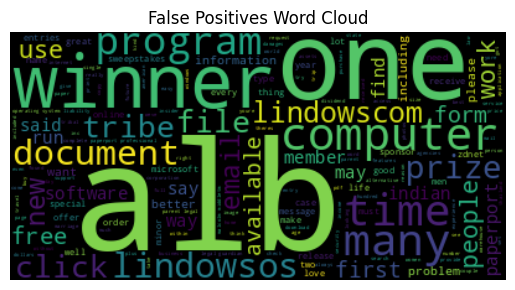

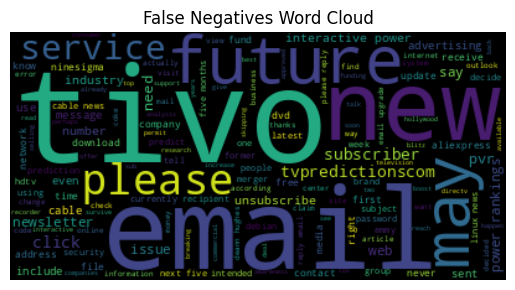

In [ ]:
# Display Wordclouds
plt.imshow(fp_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("False Positives Word Cloud")
plt.show()

plt.imshow(fn_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("False Negatives Word Cloud")
plt.show()

In [ ]:
# Combine emails to fit a consistent vocabulary
combined_text = pd.concat([fp["cleaned text"], fn["cleaned text"]])
tfidf = TfidfVectorizer(ngram_range=(2, 2), max_features=100, stop_words='english')
tfidf.fit(combined_text)

# Transform separately
X_fp = tfidf.transform(fp["cleaned text"])
X_fn = tfidf.transform(fn["cleaned text"])

# Get feature names
features = tfidf.get_feature_names_out()

# Get mean TF-IDF scores per feature
mean_fp = X_fp.mean(axis=0).A1  # Convert to 1D array
mean_fn = X_fn.mean(axis=0).A1

# Sort by top TF-IDF scores
top_fp_indices = np.argsort(mean_fp)[::-1][:10]
top_fn_indices = np.argsort(mean_fn)[::-1][:10]

print("Top words in False Positives:")
print([features[i] for i in top_fp_indices])

print("\nTop words in False Negatives:")
print([features[i] for i in top_fn_indices])

Top words in False Positives:
['aug 2008', 'sep 2002', '06 aug', 'wed 06', 'let know', 'mailing list', 'http www', 'best regards', 'email address', 'want receive']

Top words in False Negatives:
['aug 2008', 'http www', 'linux news', 'mailing list', 'finance house', 'ninesigma com', 'want receive', 'vice president', 'email address', 'reply email']


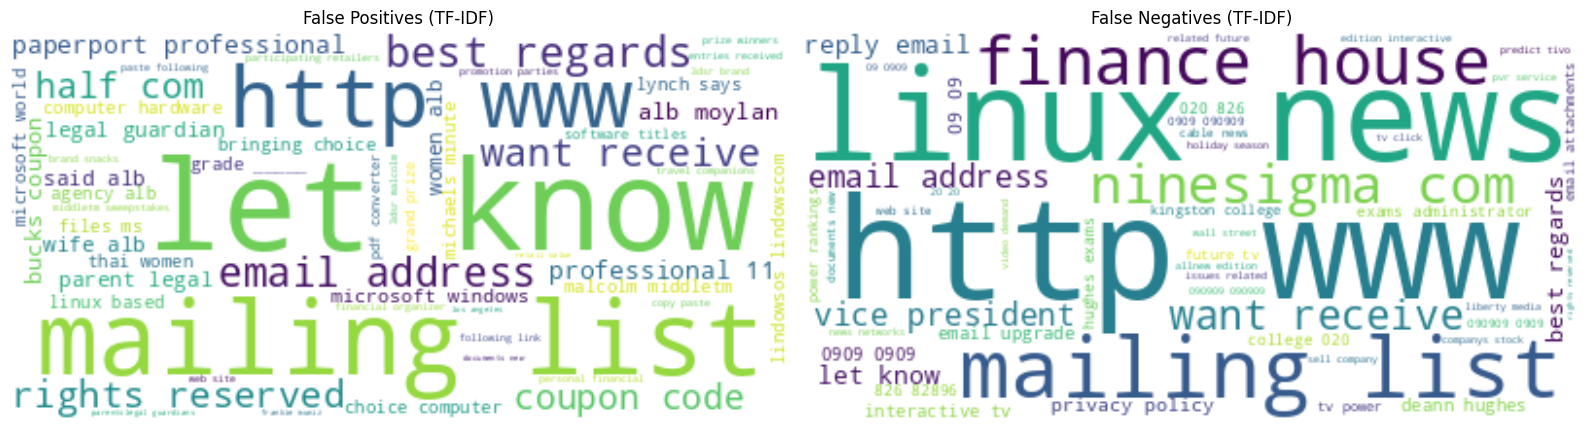

In [ ]:
# Create {word: tfidf_score} dicts
fp_tfidf_dict = {features[i]: mean_fp[i] for i in range(len(features))}
fn_tfidf_dict = {features[i]: mean_fn[i] for i in range(len(features))}

# Filter out date tokens and short words (length < 3)
fp_tfidf_filtered = {
    word: score
    for word, score in fp_tfidf_dict.items()
    if len(word) >= 3 and not is_date_token(word)
}
fn_tfidf_filtered = {
    word: score
    for word, score in fn_tfidf_dict.items()
    if len(word) >= 3 and not is_date_token(word)
}

# Generate word clouds from TF-IDF scores
fp_wc = WordCloud(background_color='white').generate_from_frequencies(fp_tfidf_filtered)
fn_wc = WordCloud(background_color='white').generate_from_frequencies(fn_tfidf_filtered)

fp_wc.to_file(os.path.join(report_path, "tfidf_false_positives_wordcloud.png"))
fn_wc.to_file(os.path.join(report_path, "tfidf_false_negatives_wordcloud.png"))

# Plot side-by-side
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(fp_wc, interpolation='bilinear')
plt.axis('off')
plt.title("False Positives (TF-IDF)")

plt.subplot(1, 2, 2)
plt.imshow(fn_wc, interpolation='bilinear')
plt.axis('off')
plt.title("False Negatives (TF-IDF)")

plt.tight_layout()
plt.show()

In [ ]:
df.to_csv(os.path.join(report_path, "fold2_misclassified_emails_with_features.csv"), index=False)